In [18]:
import numpy as np
import mne
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mne.decoding import CSP
from mne.decoding import get_spatial_filter_from_estimator

In [2]:
file = "C:\\Users\\Luchitha\Documents\\BCI\BCI_IV\\dataset\\A01T.gdf"
raw = mne.io.read_raw_gdf(file, preload=True)

Extracting GDF parameters from C:\Users\Luchitha\Documents\BCI\BCI_IV\dataset\A01T.gdf...
Setting channel info structure...
Could not determine channel type of the following channels, they will be set as EEG:
EEG-Fz, EEG, EEG, EEG, EEG, EEG, EEG, EEG-C3, EEG, EEG-Cz, EEG, EEG-C4, EEG, EEG, EEG, EEG, EEG, EEG, EEG, EEG-Pz, EEG, EEG, EOG-left, EOG-central, EOG-right
Creating raw.info structure...


Reading 0 ... 672527  =      0.000 ...  2690.108 secs...


C:\Users\Luchitha\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:144: RuntimeWarning: Channel names are not unique, found duplicates for: {'EEG'}. Applying running numbers for duplicates.
  next(self.gen)


Using matplotlib as 2D backend.


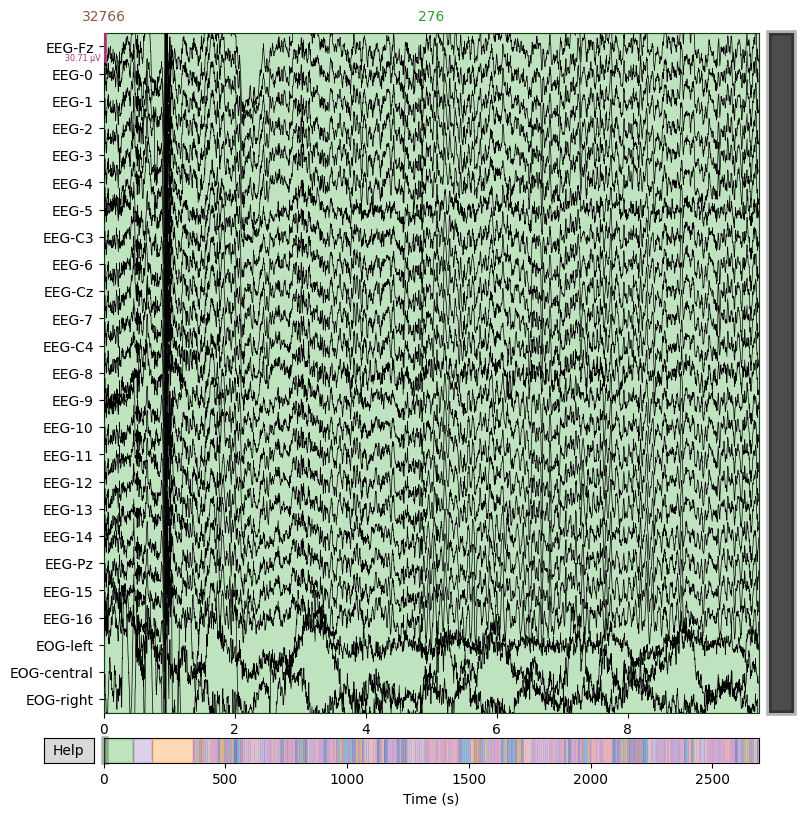

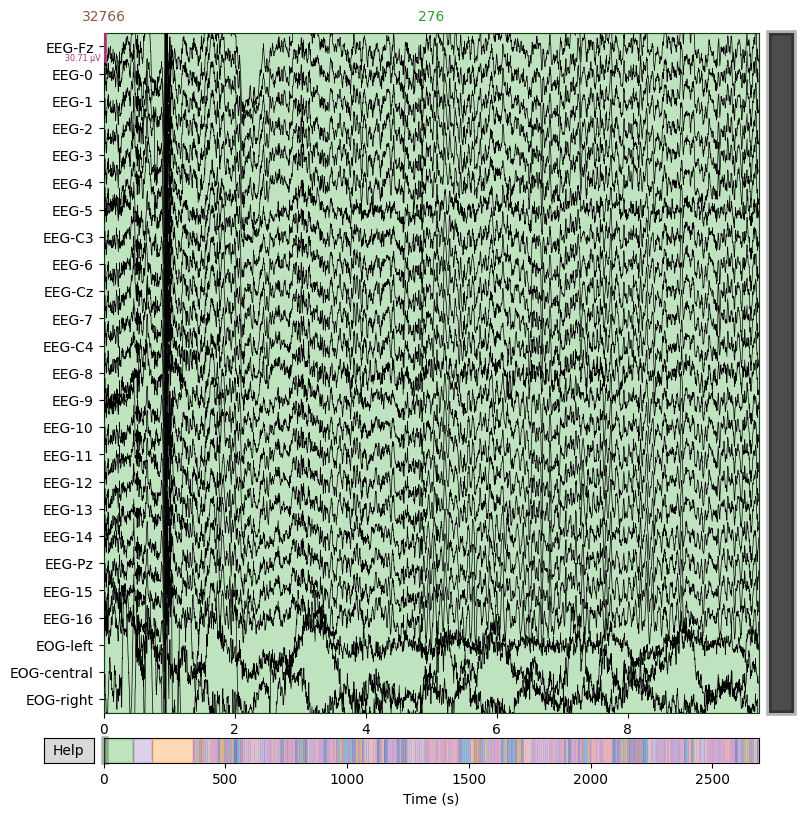

In [3]:
raw.plot(n_channels=25, scalings='auto')


removes:

DC drift

eye movement drift

high-frequency EMG

In [4]:
raw.drop_channels(['EOG-left', 'EOG-central', 'EOG-right'])

<RawGDF | A01T.gdf, 22 x 672528 (2690.1 s), ~112.9 MiB, data loaded>

In [5]:
raw.filter(8, 30, fir_design="firwin")


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 30 Hz

FIR filter parameters


---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 413 samples (1.652 s)



<RawGDF | A01T.gdf, 22 x 672528 (2690.1 s), ~112.9 MiB, data loaded>

In [6]:
raw.notch_filter(50)


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



<RawGDF | A01T.gdf, 22 x 672528 (2690.1 s), ~112.9 MiB, data loaded>

In [7]:
events, ann_event_id = mne.events_from_annotations(raw)
event_id = {
    'LH': ann_event_id['769'],
    'RH': ann_event_id['770'],
    'F':  ann_event_id['771'],
    'T':  ann_event_id['772']
}


Used Annotations descriptions: [np.str_('1023'), np.str_('1072'), np.str_('276'), np.str_('277'), np.str_('32766'), np.str_('768'), np.str_('769'), np.str_('770'), np.str_('771'), np.str_('772')]


In [8]:


epochs = mne.Epochs(
    raw, events,
    event_id=event_id,
    tmin=2.0, tmax=6.0,
    baseline=None,  # just skip baseline correction
    preload=True
)



Not setting metadata


288 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 288 events and 1001 original time points ...
1 bad epochs dropped


In [9]:
print("Original trials:", len(events))
print("Remaining epochs:", len(epochs))



Original trials: 603
Remaining epochs: 287


In [10]:
print(epochs.get_data().shape)

(287, 22, 1001)


In [11]:
X = epochs.get_data()
X_feat = np.log(np.var(X, axis=2))


In [12]:
y = epochs.events[:, -1]
print(y)

[10  9  8  7  7  8  9 10  8  9  7  7  7 10  8  8  7  7  9  7  8 10 10  9
  7 10 10  8 10 10  8  7  8  9  9  9 10  9  7 10  8  9  8  9 10  8  9  7
  7  7 10  8  7  9  7  9  8 10  7  9  9  7  9  8 10 10 10  9  7 10  8 10
  8  7  9  8  7  9  9  7  9 10 10  8  7  8 10  8 10  9  8  8  8  9 10  7
  8 10  7  9  9 10  7  7  9  8 10 10 10  8  7  9  8 10  7 10  9  8 10 10
  7  8  8  9 10  8  7  7 10  8  7  9  8  8  9  7 10  9  9  9  9  7  8  7
  8  7  7  9  9  8  9 10  7 10  7  7  8 10  9  8 10  9 10  9 10  8  8 10
  7  8  8  8  9 10  7 10  7  9  7 10  7  9  7  8  9  9 10  7  8 10  8  9
  9  7 10  8 10  7  7  9  9  8 10  8  8  7  8 10 10  8  8  8  8 10 10  9
 10  7  8  9  8  7 10  7 10  7  7  7  7  9  9 10  8  9  9  9 10  9  7  9
  7 10  8 10 10  9 10 10  9  8 10  9  7  8  8  8  9  8 10  9 10  8  9  7
 10  7  9 10  7  9  7  8  8  7 10  7 10  9  9  7  9  8  8  7  9  7  8]


In [13]:
clf = LinearDiscriminantAnalysis()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(clf, X_feat, y, cv=cv)
print("Mean accuracy:", scores.mean())


Mean accuracy: 0.42153660012099203


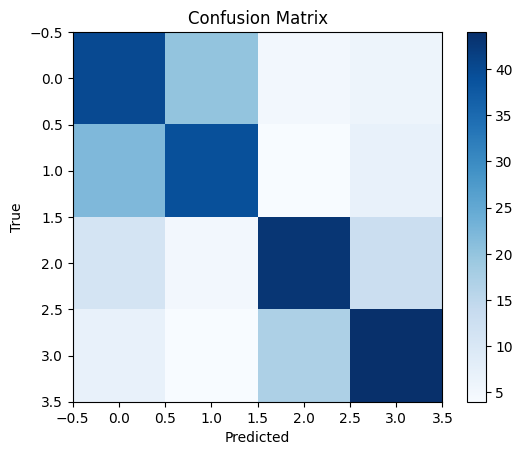

In [14]:
clf.fit(X_feat, y)
y_pred = clf.predict(X_feat)

cm = confusion_matrix(y, y_pred)
plt.imshow(cm, cmap="Blues")
plt.colorbar()
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [23]:
X = epochs.get_data().astype(np.float64)  # CSP needs float64
y = epochs.events[:, 2]

In [24]:
print(np.unique(y))  # should show the unique class labels

[ 7  8  9 10]


In [16]:
print(np.isnan(X).any())  # Check for NaNs
print(np.isinf(X).any())  # Check for Infs

False
False


In [20]:





# 2. Fit CSP
csp = CSP(n_components=6, reg=None, log=True)
X_csp = csp.fit_transform(X, y)





Computing rank from data with rank=None
    Using tolerance 0.00011 (2.2e-16 eps * 22 dim * 2.3e+10  max singular value)
    Estimated rank (data): 22
    data: rank 22 computed from 22 data channels with 0 projectors
Reducing data rank from 22 -> 22
Estimating class=7 covariance using EMPIRICAL
Done.
Estimating class=8 covariance using EMPIRICAL
Done.
Estimating class=9 covariance using EMPIRICAL
Done.
Estimating class=10 covariance using EMPIRICAL
Done.


In [ ]:
# Wrap CSP as an “estimator” and get the spatial filter
spatial_filter = get_spatial_filter_from_estimator(csp, info=epochs.info)

# Plot the spatial patterns
spatial_filter.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)')


AttributeError: 'NoneType' object has no attribute 'ndim'

In [ ]:
print(X.shape, y.shape)
print(X.ndim)  # should print 3
print(y.ndim)  # should print 1


(287, 22, 1001) (287,)
3
1


In [22]:
  # Plot patterns (use new API)
spatial_filter = get_spatial_filter_from_estimator(csp, info=epochs.info)
spatial_filter.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)')



AttributeError: 'NoneType' object has no attribute 'ndim'